<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/form-8k/8k-item-4-01-tutorial-website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Accountant Changes and Disagreement Reports

We illustrate how to perform an exploratory data analysis on disclosures informing investors about changes of accountant and potential disagreements with the former accountant of publicly traded companies on U.S. stock exchanges. These changes are disclosed in Form 8-K filings with the SEC, specifically under Item 4.01, titled "Changes in Registrant’s Certifying Accountant." These disclosures are presented in text form by companies. Utilizing our Structured Data API, we extract and structure the relevant information from the text, making it available for detailed analysis.

Our analysis will focus on several key areas:

- Number of Item 4.01 disclosures made each year from 2004 to 2023, per quarter, month and at what time of the day (pre-market, regular market, after-market)
- Distribution of disclosures across structured data fields, such as the proportion of disclosures reporting a going concern
- Number of disagreements and resolution thereof disclosed per year
- Disclosed weaknesses in internal control over financial reporting (ICFR)
- Identification of the reason for the termination of the engagement with the former accountant
- Identification of the types of opinion expressed in the audit reports


## Data Loading and Preparation

To load and prepare the data, we will use the [Form 8-K Item 4.01 Structured Data API](https://sec-api.io/docs/form-8k-data-item4-1-search-api) to download all structured data related to Form 8-K filings that include Item 4.01 disclosures. The data spanning the years 2004 to 2024 is saved to a JSONL file `./form-8k-item-4-01-structured-data.jsonl`.

In [5]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick

style.use("default")

params = {
    "axes.labelsize": 8, "font.size": 8, "legend.fontsize": 8,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "font.family": "sans-serif",
    "axes.spines.top": False, "axes.spines.right": False, "grid.color": "grey",
    "axes.grid": True, "axes.grid.axis": "y", "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)

In [ ]:
!pip install sec-api

In [ ]:
from sec_api import Form_8K_Item_X_Api

item_X_api = Form_8K_Item_X_Api("YOUR_API_KEY")

YEARS = range(2024, 2003, -1)  # from 2024 to 2004
TARGET_FILE = "./form-8k-item-4-01-structured-data.jsonl"

if not os.path.exists(TARGET_FILE):
    for year in YEARS:
        done = False
        search_from = 0
        year_counter = 0

        while not done:
            searchRequest = {
                "query": f"item4_01:* AND filedAt:[{year}-01-01 TO {year}-12-31]",
                "from": search_from,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }

            response = item_X_api.get_data(searchRequest)

            if len(response["data"]) == 0:
                break

            search_from += 50
            year_counter += len(response["data"])

            with open(TARGET_FILE, "a") as f:
                for entry in response["data"]:
                    f.write(json.dumps(entry) + "\n")

        print(f"Finished loading {year_counter} Item 4.01 for year {year}")
else:
    print("File already exists, skipping download")

Finished loading 1003 Item 4.01 for year 2024
Finished loading 844 Item 4.01 for year 2023
Finished loading 793 Item 4.01 for year 2022
Finished loading 772 Item 4.01 for year 2021
Finished loading 606 Item 4.01 for year 2020
Finished loading 717 Item 4.01 for year 2019
Finished loading 837 Item 4.01 for year 2018
Finished loading 982 Item 4.01 for year 2017
Finished loading 957 Item 4.01 for year 2016
Finished loading 1216 Item 4.01 for year 2015
Finished loading 1410 Item 4.01 for year 2014
Finished loading 1566 Item 4.01 for year 2013
Finished loading 1173 Item 4.01 for year 2012
Finished loading 1448 Item 4.01 for year 2011
Finished loading 1646 Item 4.01 for year 2010
Finished loading 2102 Item 4.01 for year 2009
Finished loading 1628 Item 4.01 for year 2008
Finished loading 1974 Item 4.01 for year 2007
Finished loading 2175 Item 4.01 for year 2006
Finished loading 2104 Item 4.01 for year 2005
Finished loading 771 Item 4.01 for year 2004


In [ ]:
structured_data = pd.read_json(TARGET_FILE, lines=True)

structured_data["filedAt"] = pd.to_datetime(structured_data["filedAt"], utc=True)
structured_data["filedAt"] = structured_data["filedAt"].dt.tz_convert("US/Eastern")
structured_data["year"] = structured_data["filedAt"].dt.year
structured_data["month"] = structured_data["filedAt"].dt.month
structured_data["dayOfWeek"] = structured_data["filedAt"].dt.day_name()
# filedAtClass: 
# preMarket (4:00 AM to 9:30 AM), 
# regularMarket (9:30 AM to 4:00 PM), 
# afterMarket (4:00 PM to 8:00 PM), 
# other (8:00 PM to 10:00 PM)
structured_data["filedAtClass"] = structured_data["filedAt"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "other"
        )
    )
)

In [12]:
unique_years = structured_data["year"].nunique()
unique_companies = structured_data["cik"].nunique()
print(
    f"Loaded {len(structured_data):,} Item 4.01 structured data records from {YEARS[-1]} to {YEARS[0]}, \ncovering {unique_years} years and {unique_companies:,} unique companies."
)
structured_data.head()

Loaded 26,724 Item 4.01 structured data records from 2004 to 2024, 
covering 21 years and 10,495 unique companies.


,id,accessionNo,formType,filedAt,periodOfReport,cik,ticker,companyName,items,item4_01,item5_02,item4_02,year,month,dayOfWeek,filedAtClass
0,4ceff8128ec58ee74c3a30d2682ea462,0001599916-24-000323,8-K,2024-12-31 12:22:18-05:00,2024-05-03,1367408,OILY,Sino American Oil Co,[Item 4.01: Changes in Registrant's Certifying...,{'keyComponents': 'Sino American Oil Co. dismi...,NaN,NaN,2024,12,Tuesday,regularMarket
1,bab09dc10fa2f239ef5e6abcc3971d6c,0001683168-24-009057,8-K,2024-12-31 08:36:36-05:00,2024-12-31,1827855,MCLE,Medicale Corp.,[Item 4.01: Changes in Registrant's Certifying...,{'keyComponents': 'Medicale Corp. dismissed Gr...,NaN,NaN,2024,12,Tuesday,preMarket
2,80d01f5a70c47acac5f31e3c1b222785,0001493152-24-052550,8-K,2024-12-30 17:13:59-05:00,2024-06-17,1850767,ACUT,Accustem Sciences Inc.,[Item 4.01: Changes in Registrant's Certifying...,"{'keyComponents': 'On June 17, 2024, Mercurius...",NaN,NaN,2024,12,Monday,afterMarket
3,beb9b44a4b20c882bacffe1cf9f39ac9,0001493152-24-052512,8-K,2024-12-30 16:41:43-05:00,2024-12-30,1643988,LPTV,"Loop Media, Inc.",[Item 4.01: Changes in Registrant's Certifying...,{'keyComponents': 'The Company dismissed Marcu...,NaN,NaN,2024,12,Monday,afterMarket
4,0cf18570d923c6e72e44a4a567704a04,0001213900-24-112993,8-K,2024-12-27 13:45:06-05:00,2024-12-20,2034406,,Tortoise Capital Series Trust,[Item 4.01: Changes in Registrant's Certifying...,"{'keyComponents': 'As a result of the Mergers,...",NaN,NaN,2024,12,Friday,regularMarket


In [14]:
print(structured_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26724 entries, 0 to 26723
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype                     
---  ------          --------------  -----                     
 0   id              26724 non-null  object                    
 1   accessionNo     26724 non-null  object                    
 2   formType        26724 non-null  object                    
 3   filedAt         26724 non-null  datetime64[ns, US/Eastern]
 4   periodOfReport  26724 non-null  object                    
 5   cik             26724 non-null  int64                     
 6   ticker          20390 non-null  object                    
 7   companyName     26724 non-null  object                    
 8   items           26724 non-null  object                    
 9   item4_01        26724 non-null  object                    
 10  item5_02        1895 non-null   object                    
 11  item4_02        263 non-null    object                

### Item 4.01 Example

In [46]:
print(json.dumps(structured_data["item4_01"][0], indent=2))

{
  "keyComponents": "Sino American Oil Co. dismissed BF Borgers CPA PC as its independent auditor on May 3, 2024, due to BF Borgers not being permitted to appear or practice before the SEC. Subsequently, the company appointed Michael Gillespie & Associates, PLLC as its new auditor on August 28, 2024.",
  "newAccountantDate": "2024-08-28",
  "engagedNewAccountant": true,
  "formerAccountantDate": "2024-05-03",
  "engagementEndReason": "dismissal",
  "formerAccountantName": "BF Borgers CPA PC",
  "newAccountantName": "Michael Gillespie & Associates, PLLC",
  "reportedDisagreements": false,
  "reportableEventsExist": true,
  "reportableEventsList": [
    "Identified material weaknesses in internal control over financial reporting."
  ],
  "reportedIcfrWeakness": true,
  "opinionType": "unqualified",
  "goingConcern": true,
  "goingConcernDetail": "The reports included an explanatory paragraph relating to the Company\u2019s ability to continue as a going concern.",
  "approvedChange": tru

## Vizualization of Change-of-Accountant Disclosures over Time


In [16]:
item_4_01_counts = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year"])
    .size()
    .to_frame(name="count")
)

print(f"Item 4.01 counts from {YEARS[-1]} to {YEARS[0]}")
item_4_01_counts.T

Item 4.01 counts from 2004 to 2024


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
count,771,2104,2175,1974,1628,2102,1646,1448,1173,1566,...,1216,957,982,837,717,606,772,793,844,1003


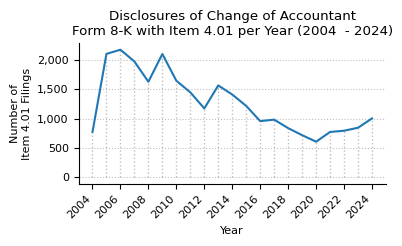

In [21]:
def plot_timeseries(ts, title):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ts["count"].plot(ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of\nItem 4.01 Filings")
    ax.set_xticks(np.arange(2004, 2025, 2))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_xlim(2003, 2025)
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha="right")

    for year in YEARS:
        year_y_max = ts.loc[year, "count"]
        ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.tight_layout()
    plt.show()


plot_timeseries(
    item_4_01_counts,
    title="Disclosures of Change of Accountant\nForm 8-K with Item 4.01 per Year (2004  - 2024)",
)

In [22]:
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)

counts_qtr_yr_piv = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "qtr"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)

print(f"Item 4.01 counts by quarter from 2004 to 2024.")
counts_qtr_yr_piv.T

Item 4.01 counts by quarter from 2004 to 2024.


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
qtr,,,,,,,,,,,,,,,,,,,,,
1,0,462,586,572,529,387,494,478,306,441,...,315,245,257,244,191,184,172,163,175,246
2,0,632,606,527,387,433,379,415,267,422,...,338,292,260,217,232,157,184,198,234,404
3,227,550,496,439,322,789,413,232,252,371,...,312,188,223,183,148,111,222,215,211,171
4,544,460,487,436,390,493,360,323,348,332,...,251,232,242,193,146,154,194,217,224,182


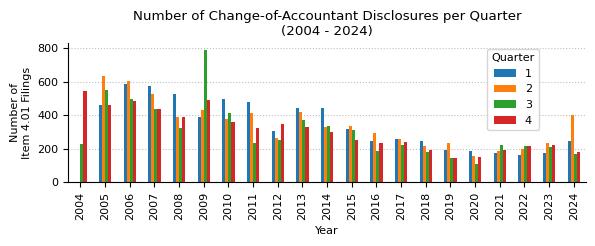

In [24]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(6, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(0.92, 1))
ax.set_title("Number of Change-of-Accountant Disclosures per Quarter\n(2004 - 2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of\nItem 4.01 Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

In [25]:
counts_month_yr_piv = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "month"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)

print(f"Item 4.01 counts by month from 2004 to 2024.")
counts_month_yr_piv

Item 4.01 counts by month from 2004 to 2024.


month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2004,0,0,0,0,0,0,0,61,166,211,174,159
2005,130,155,177,218,185,229,177,209,164,151,178,131
2006,188,155,243,208,202,196,163,166,167,160,155,172
2007,175,202,195,201,185,141,157,146,136,172,147,117
2008,212,155,162,148,129,110,110,103,109,128,141,121
2009,141,94,152,185,140,108,127,329,333,287,105,101
2010,190,119,185,160,114,105,112,174,127,131,114,115
2011,153,123,202,172,115,128,86,80,66,94,124,105
2012,78,91,137,105,85,77,67,112,73,114,123,111


In [27]:
print(f"Descriptive statistics for Item 4.01 counts by month from 2004 to 2024.")
month_stats = (
    counts_month_yr_piv.loc[2005:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Item 4.01 counts by month from 2004 to 2024.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,20,20,20,20,20,20,20,20,20,20,20,20
mean,112,97,136,127,112,106,98,113,98,109,96,92
std,55,46,50,52,51,43,41,69,67,56,40,32
min,39,41,74,54,34,63,46,29,36,49,32,43
2.5%,39,43,77,54,37,64,47,37,36,51,38,45
50%,94,92,126,114,101,102,86,104,78,100,88,89
97.5%,202,180,224,213,208,213,170,272,254,232,167,153
max,212,202,243,218,214,229,177,329,333,287,178,172


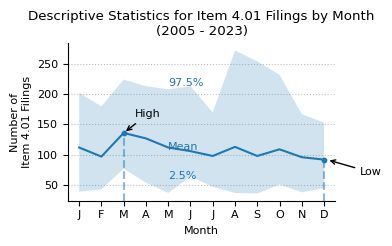

In [ ]:
def plot_box_plot_as_line(
    data: pd.DataFrame,
    x_months=True,
    title="",
    x_label="",
    x_pos_mean_label=2,
    pos_labels=None,  # {"mean": {"x": 2, "y": 150}, "upper": {"x": 2, "y": 150}, "lower": {"x": 2, "y": 150}},
    pos_high_low=None,  # {"high": {"x": 2, "y": 150}, "low": {"x": 2, "y": 150}},
    y_label="",
    y_formatter=lambda x, p: "{:.0f}".format(int(x) / 1000),
    show_high_low_labels=True,
    show_inline_labels=True,
    show_bands=True,
    figsize=(4, 2.5),
    line_source="mean",
):
    fig, ax = plt.subplots(figsize=figsize)

    line_to_plot = data[line_source]
    lower_label = "2.5%"
    upper_label = "97.5%"
    lower = data[lower_label]
    upper = data[upper_label]

    line_to_plot.plot(ax=ax)

    if show_bands:
        ax.fill_between(line_to_plot.index, lower, upper, alpha=0.2)

    if x_months:
        ax.set_xlim(0.5, 12.5)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_formatter))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ymin, ymax = ax.get_ylim()
    y_scale = ymax - ymin

    max_x = int(line_to_plot.idxmax())
    max_y = line_to_plot.max()
    min_x = int(line_to_plot.idxmin())
    min_y = line_to_plot.min()

    ax.axvline(
        max_x,
        ymin=0,
        ymax=((max_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(max_x, max_y, color="tab:blue", s=10)
    ax.axvline(
        min_x,
        ymin=0,
        ymax=((min_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(min_x, min_y, color="tab:blue", s=10)

    x_pos_mean_label_int = int(x_pos_mean_label)
    if show_inline_labels:
        mean_x = x_pos_mean_label
        mean_y = line_to_plot.iloc[x_pos_mean_label_int] * 1.02
        upper_x = x_pos_mean_label
        upper_y = upper.iloc[x_pos_mean_label_int]
        lower_x = x_pos_mean_label
        lower_y = lower.iloc[x_pos_mean_label_int] * 0.95

        if pos_labels:
            mean_x = pos_labels["mean"]["x"]
            mean_y = pos_labels["mean"]["y"]
            upper_x = pos_labels["upper"]["x"]
            upper_y = pos_labels["upper"]["y"]
            lower_x = pos_labels["lower"]["x"]
            lower_y = pos_labels["lower"]["y"]

        ax.text(mean_x, mean_y, "Mean", color="tab:blue", fontsize=8)
        ax.text(upper_x, upper_y, upper_label, color="tab:blue", fontsize=8)
        ax.text(lower_x, lower_y, lower_label, color="tab:blue", fontsize=8)

    if show_high_low_labels:
        high_x_origin = max_x
        high_y_origin = max_y
        high_x_label = high_x_origin + 0.5
        high_y_label = high_y_origin + 0.1 * y_scale
        if pos_high_low:
            high_x_label = pos_high_low["high"]["x"]
            high_y_label = pos_high_low["high"]["y"]
        ax.annotate(
            "High",
            (high_x_origin, high_y_origin),
            xytext=(high_x_label, high_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        low_x_origin = min_x * 1.01
        low_y_origin = min_y
        low_x_label = low_x_origin + 1.5
        low_y_label = low_y_origin - 0.1 * y_scale
        if pos_high_low:
            low_x_label = pos_high_low["low"]["x"]
            low_y_label = pos_high_low["low"]["y"]
        ax.annotate(
            "Low",
            (low_x_origin, low_y_origin),
            xytext=(low_x_label, low_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

    ax.grid(axis="x")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_box_plot_as_line(
    data=month_stats.T,
    title="Descriptive Statistics for Item 4.01 Filings by Month\n(2005 - 2024)",
    x_label="Month",
    y_label="Number of\nItem 4.01 Filings",
    y_formatter=lambda x, p: "{:.0f}".format(int(x)),
    x_pos_mean_label=5,
)

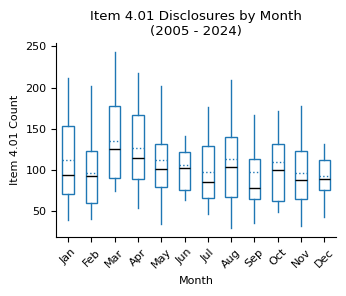

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 3))

counts_month_yr_piv.loc[2005:].boxplot(
    ax=ax,
    grid=False,
    showfliers=False,
    flierprops=dict(marker="o", markersize=3),
    patch_artist=True,
    boxprops=dict(facecolor="white", color="tab:blue"),
    showmeans=True,
    meanline=True,
    meanprops={"color": "tab:blue", "linestyle": ":"},
    medianprops={"color": "black"},
    capprops={"color": "none"},
)

ax.set_title("Item 4.01 Disclosures by Month\n(2005 - 2024)")
ax.set_xlabel("Month")
ax.set_ylabel("Item 4.01 Count")
xticklabels = [pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
counts_filedAtClass = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["filedAtClass"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Publication Time")
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("regularMarket", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)
counts_filedAtClass = counts_filedAtClass.reindex(counts_filedAtClass.index[::-1])

print(
    f"Item 4.01 counts by pre-market, regular market hours,\nand after-market publication time (2004 - 2024)."
)
counts_filedAtClass

Item 4.01 counts by pre-market, regular market hours,
and after-market publication time (2004 - 2024).


,Count,Pct
Publication Time,,
other,637,2%
Pre-Market (4:00 - 9:30 AM),"1,668",6%
Market Hours (9:30 AM - 4:00 PM),"10,647",40%
After Market (4:00 - 8:00 PM),"13,772",52%


In [ ]:
counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["dayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"Item 4.01 disclosures by day of the week (2004 - 2024).")
counts_dayOfWeek.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]

Item 4.01 disclosures by day of the week (2004 - 2024).


,Count,Pct
Day of the Week,,
Monday,"4,830",18%
Tuesday,"5,285",20%
Wednesday,"5,363",20%
Thursday,"5,320",20%
Friday,"5,926",22%


## Distribution of Disclosures by Their Characteristics


In [55]:
structured_data["item4_01"].apply(
    lambda x: x["consultedNewAccountant"] if "consultedNewAccountant" in x else None
).value_counts().to_frame().reset_index().rename(columns={"item4_01": "value"})

,value,count
0,False,20423
1,True,125


In [ ]:
bool_variables_to_analyze = [
    "engagedNewAccountant",
    "consultedNewAccountant",
    "reportedDisagreements",
    "resolvedDisagreements",
    "reportableEventsExist",
    "reportedIcfrWeakness",
    "remediatedIcfrWeakness",
    "goingConcern",
    "auditDisclaimer",
    "authorizedInquiry",
    "approvedChange",
]

var_to_label = {
    "engagedNewAccountant": "New Accountant was Engaged",
    "consultedNewAccountant": "Consulted new Accountant Prior to Engagement",
    "reportedDisagreements": "Disagreements Reported",
    "resolvedDisagreements": "Reported Disagreements were Resolved",
    "reportableEventsExist": "Reportable Events exist",
    "reportedIcfrWeakness": "ICFR Weakness Reported",
    "remediatedIcfrWeakness": "Reported ICFR Weakness Remediated",
    "goingConcern": "Report includes Going Concern Statement",
    "auditDisclaimer": "Audit Report includes Disclaimer of Opinion",
    "authorizedInquiry": "Former Accountant Authorized to Respond to Inquiries",
    "approvedChange": "Change Approved by Board or Audit Committee",
}


total_samples = len(structured_data)
# Create a row for the total samples
total_row = pd.DataFrame(
    {
        "Samples": [f"{total_samples:,.0f}"],
        "Pct.": [""],
        "Pct. tot.": [100],
    },
    index=pd.MultiIndex.from_tuples([("Total", "")], names=["Variable", "Value"]),
)


bool_variables_stats = []

for variable in bool_variables_to_analyze:
    variable_stats = (
        structured_data["item4_01"]
        .apply(lambda x: x[variable] if variable in x else None)
        .value_counts()
        .to_frame()
        .reset_index()
        .rename(columns={"item4_01": "value"})
    )
    variable_stats = variable_stats.sort_values(by="value", ascending=False)
    variable_stats["pct"] = (
        variable_stats["count"] / variable_stats["count"].sum() * 100
    ).round(1)
    variable_stats["pct_tot"] = (variable_stats["count"] / total_samples * 100).round(1)
    variable_stats.index = pd.MultiIndex.from_tuples(
        [(variable, row["value"]) for _, row in variable_stats.iterrows()],
    )
    variable_stats.drop(columns="value", inplace=True)

    bool_variables_stats.append(variable_stats)

bool_variables_stats = pd.concat(bool_variables_stats, axis=0)
bool_variables_stats.index.set_names(["Variable", "Value"], inplace=True)
bool_variables_stats.rename(
    index=var_to_label,
    columns={"count": "Samples", "pct": "Pct.", "pct_tot": "Pct. tot."},
    inplace=True,
)
bool_variables_stats["Samples"] = bool_variables_stats["Samples"].apply(
    lambda x: f"{x:,.0f}"
)


bool_variables_stats = pd.concat([total_row, bool_variables_stats])


print(
    f"Number of change-of-accountant filings by \ntheir disclosed characteristics (2004 - 2024):"
)
bool_variables_stats

Number of change-of-accountant filings by 
their disclosed characteristics (2004 - 2024):


Samples  Pct.  \
Variable                                           Value                 
Total                                                     26,724         
New Accountant was Engaged                         True   20,913  97.8   
                                                   False     476   2.2   
Consulted new Accountant Prior to Engagement       True      125   0.6   
                                                   False  20,423  99.4   
Disagreements Reported                             True      419   1.7   
                                                   False  23,848  98.3   
Reported Disagreements were Resolved               True      160  42.0   
                                                   False     221  58.0   
Reportable Events exist                            True    2,441  13.1   
                                                   False  16,192  86.9   
ICFR Weakness Reported                             True    3,281  64.5   
                                                   False   1,805  35.5   
Reported ICFR Weakness Remediated                  True      576  56.4   
                                                   False     445  43.6   
Report includes Going Concern Statement            True   10,562  95.2   
                                                   False     532   4.8   
Audit Report includes Disclaimer of Opinion        True       58   1.7   
                                                   False   3,397  98.3   
Former Accountant Authorized to Respond to Inqu... True    2,501  96.6   
                                                   False      87   3.4   
Change Approved by Board or Audit Committee        True   19,588  98.4   
                                                   False     319   1.6   

                                                          Pct. tot.  
Variable                                           Value             
Total                                                         100.0  
New Accountant was Engaged                         True        78.3  
                                                   False        1.8  
Consulted new Accountant Prior to Engagement       True         0.5  
                                                   False       76.4  
Disagreements Reported                             True         1.6  
                                                   False       89.2  
Reported Disagreements were Resolved               True         0.6  
                                                   False        0.8  
Reportable Events exist                            True         9.1  
                                                   False       60.6  
ICFR Weakness Reported                             True        12.3  
                                                   False        6.8  
Reported ICFR Weakness Remediated                  True         2.2  
                                                   False        1.7  
Report includes Going Concern Statement            True        39.5  
                                                   False        2.0  
Audit Report includes Disclaimer of Opinion        True         0.2  
                                                   False       12.7  
Former Accountant Authorized to Respond to Inqu... True         9.4  
                                                   False        0.3  
Change Approved by Board or Audit Committee        True        73.3  
                                                   False        1.2

Now, we count the occurrences when the flags have a value of interest. E.g., "True" for "Disagreements Reported" and "False" for "Change Approved by Board or Audit Committee"


In [60]:
bool_variables_to_analyze_true = [
    "consultedNewAccountant",
    "reportedDisagreements",
    "resolvedDisagreements",
    "reportableEventsExist",
    "reportedIcfrWeakness",
    "remediatedIcfrWeakness",
    "goingConcern",
    "auditDisclaimer",
]
bool_variables_to_analyze_false = ["authorizedInquiry", "approvedChange"]

events_var_labels = {
    "consultedNewAccountant": "Consulted with New Accountant",
    "reportedDisagreements": "Reported Disagreements",
    "resolvedDisagreements": "Reported Disagreements Resolved",
    "reportableEventsExist": "Reportable Events in Filing",
    "reportedIcfrWeakness": "ICFR Weakness Reported",
    "remediatedIcfrWeakness": "Reported ICFR Weakness Remediated",
    "goingConcern": "Report includes Going Concern Statement",
    "auditDisclaimer": "Audit Report includes Disclaimer of Opinion",
    "authorizedInquiry": "Former Accountant Not Authorized to Respond to Inquiries",
    "approvedChange": "Change Not Approved by Board or Audit Committee",
}

item_4_01_exploded = structured_data["item4_01"].apply(pd.Series)
item_4_01_exploded = pd.concat([structured_data, item_4_01_exploded], axis=1)

true_count_year_pivot = pd.pivot_table(
    item_4_01_exploded,
    index="year",
    # values=["goingConcern", "reportedIcfrWeakness"],
    values=bool_variables_to_analyze_true,
    aggfunc=lambda x: (x == True).sum(),
    fill_value=0,
)

false_count_year_pivot = pd.pivot_table(
    item_4_01_exploded,
    index="year",
    values=bool_variables_to_analyze_false,
    aggfunc=lambda x: (x == False).sum(),
    fill_value=0,
)

event_counts_year_pivot = pd.concat(
    [true_count_year_pivot, false_count_year_pivot], axis=1
)
event_counts_year_pivot = event_counts_year_pivot.T
event_counts_year_pivot["total"] = event_counts_year_pivot.sum(axis=1)
event_counts_year_pivot = event_counts_year_pivot.sort_values(
    by="total", ascending=False
)


event_counts_year_pivot.rename(index=events_var_labels, inplace=True)
event_counts_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
Report includes Going Concern Statement,215,600,694,719,642,973,750,687,540,848,...,356,360,272,260,182,273,266,314,358,10562
ICFR Weakness Reported,61,269,275,219,172,122,111,74,68,117,...,109,148,125,125,118,182,188,255,239,3281
Reportable Events in Filing,57,207,206,155,108,115,83,64,53,80,...,89,94,82,92,85,132,141,175,191,2441
Reported ICFR Weakness Remediated,16,49,77,55,36,25,20,12,7,20,...,22,25,20,20,23,25,29,25,28,576
Reported Disagreements,16,46,55,38,11,28,32,28,20,31,...,7,14,7,14,8,5,5,4,10,419
Change Not Approved by Board or Audit Committee,26,67,48,32,15,16,9,9,7,12,...,7,13,10,7,3,5,4,11,10,319
Reported Disagreements Resolved,9,25,26,16,6,11,11,0,5,17,...,0,4,4,5,4,1,0,0,3,160
Consulted with New Accountant,7,9,13,8,22,5,13,4,11,5,...,2,0,4,2,3,1,2,2,2,125
Former Accountant Not Authorized to Respond to Inquiries,3,4,11,3,6,14,13,6,2,3,...,0,1,1,0,1,1,5,2,2,87
Audit Report includes Disclaimer of Opinion,0,5,16,6,7,2,6,4,4,3,...,1,1,0,3,0,0,0,0,0,58


In [61]:
top_5_events = event_counts_year_pivot.head(5)

others = event_counts_year_pivot[
    ~event_counts_year_pivot.index.isin(event_counts_year_pivot.index)
]
others = others.sum().to_frame().T
others.index = ["Others"]

top_5_events = pd.concat([top_5_events, others], axis=0)

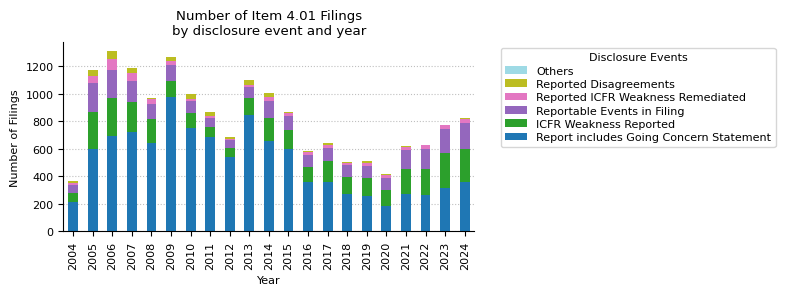

In [62]:
fig, ax = plt.subplots(figsize=(8, 3))

top_5_events.drop(columns="total").T.plot(kind="bar", stacked=True, ax=ax, cmap="tab20")

ax.set_title("Number of Item 4.01 Filings\nby disclosure event and year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]

ax.legend(
    reversed(handles),
    reversed(labels),
    title="Disclosure Events",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Disagreements


In [63]:
disagreements_year_pivot = pd.pivot_table(
    item_4_01_exploded,
    index="year",
    values=["reportedDisagreements", "resolvedDisagreements"],
    aggfunc=lambda x: (x == True).sum(),
    fill_value=0,
)


disagreements_year_pivot = disagreements_year_pivot.T
disagreements_year_pivot["total"] = disagreements_year_pivot.sum(axis=1)
disagreements_year_pivot = disagreements_year_pivot.sort_values(
    by="total", ascending=False
)
disagreements_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
reportedDisagreements,16,46,55,38,11,28,32,28,20,31,...,7,14,7,14,8,5,5,4,10,419
resolvedDisagreements,9,25,26,16,6,11,11,0,5,17,...,0,4,4,5,4,1,0,0,3,160


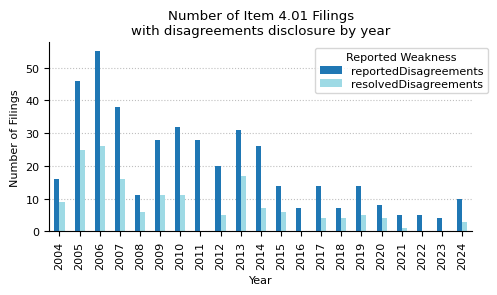

In [64]:
fig, ax = plt.subplots(figsize=(5, 3))

disagreements_year_pivot.T.drop("total").plot(
    kind="bar", stacked=False, ax=ax, cmap="tab20"
)

ax.set_title("Number of Item 4.01 Filings\nwith disagreements disclosure by year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]

ax.legend(
    handles,
    labels,
    title="Reported Weakness",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## ICFR Weaknesses


In [65]:
icfr_weaknesses_pivot = pd.pivot_table(
    item_4_01_exploded,
    index="year",
    values=[
        "remediatedIcfrWeakness",
        "reportedIcfrWeakness",
    ],
    aggfunc=lambda x: (x == True).sum(),
    fill_value=0,
)


icfr_weaknesses_pivot = icfr_weaknesses_pivot.T
icfr_weaknesses_pivot["total"] = icfr_weaknesses_pivot.sum(axis=1)
icfr_weaknesses_pivot = icfr_weaknesses_pivot.sort_values(by="total", ascending=False)
icfr_weaknesses_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
reportedIcfrWeakness,61,269,275,219,172,122,111,74,68,117,...,109,148,125,125,118,182,188,255,239,3281
remediatedIcfrWeakness,16,49,77,55,36,25,20,12,7,20,...,22,25,20,20,23,25,29,25,28,576


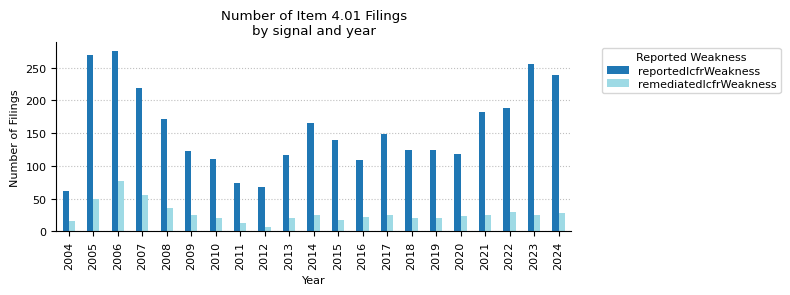

In [66]:
fig, ax = plt.subplots(figsize=(8, 3))

icfr_weaknesses_pivot.T.drop("total").plot(
    kind="bar", stacked=False, ax=ax, cmap="tab20"
)

ax.set_title("Number of Item 4.01 Filings\nby signal and year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]

ax.legend(
    handles,
    labels,
    title="Reported Weakness",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Reason for End of Engagement


In [69]:
engagementEndReason = (
    item_4_01_exploded["engagementEndReason"].explode().value_counts().to_frame().head(5)
)
engagementEndReason.index.name = "Audit Opinion Type"
engagementEndReason.columns = ["Count"]
engagementEndReason["Pct."] = (
    engagementEndReason["Count"] / engagementEndReason["Count"].sum() * 100
)
engagementEndReason["Pct."] = engagementEndReason["Pct."].round(1)
engagementEndReason["Count"] = engagementEndReason["Count"].apply(lambda x: f"{x:,.0f}")

print(
    f"Top 4 reason for end of engagement with the former accountant\nif stated in the Item 4.01 filings (2004 - 2024):"
)
engagementEndReason.head(4)

Top 4 reason for end of engagement with the former accountant
if stated in the Item 4.01 filings (2004 - 2024):


,Count,Pct.
Audit Opinion Type,,
dismissal,"14,941",65.5
resignation,"6,082",26.6
declination to stand for reappointment,"1,187",5.2
dissolution,609,2.7


In [70]:
endReason_year = item_4_01_exploded[
    ["engagementEndReason", "year", "accessionNo"]
].explode("engagementEndReason")

endReason_year_pivot = pd.pivot_table(
    endReason_year,
    index="engagementEndReason",
    columns="year",
    values="accessionNo",
    aggfunc="count",
    fill_value=0,
)

endReason_year_pivot["total"] = endReason_year_pivot.sum(axis=1)
endReason_year_pivot = endReason_year_pivot.sort_values(by="total", ascending=False)
# remove artifacts
endReason_year_pivot = endReason_year_pivot[
    endReason_year_pivot["total"] >= 0.001 * endReason_year_pivot["total"].sum()
]

endReason_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
engagementEndReason,,,,,,,,,,,,,,,,,,,,,
dismissal,364,968,1150,1046,925,1312,912,888,721,877,...,540,538,455,412,400,496,455,482,643,14941
resignation,214,537,521,473,389,379,347,281,231,359,...,229,242,215,180,107,123,161,187,166,6082
declination to stand for reappointment,39,176,100,78,48,50,96,44,30,103,...,35,34,29,21,16,29,36,59,42,1187
dissolution,4,19,50,60,28,107,33,47,45,48,...,30,16,5,4,6,7,29,18,14,609


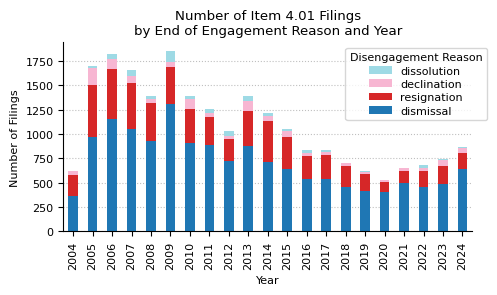

In [71]:
fig, ax = plt.subplots(figsize=(5, 3))

endReason_year_pivot.drop(columns="total").T.plot(
    kind="bar", stacked=True, ax=ax, cmap="tab20"
)

ax.set_title("Number of Item 4.01 Filings\nby End of Engagement Reason and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]

ax.legend(
    reversed(handles),
    reversed(labels),
    title="Disengagement Reason",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Opinion Types of Audit Reports


In [73]:
opinionType = item_4_01_exploded["opinionType"].explode().value_counts().to_frame().head(5)
opinionType.index.name = "Audit Opinion Type"
opinionType.columns = ["Count"]
opinionType["Pct."] = opinionType["Count"] / opinionType["Count"].sum() * 100
opinionType["Pct."] = opinionType["Pct."].round(1)
opinionType["Count"] = opinionType["Count"].apply(lambda x: f"{x:,.0f}")

print(
    f"Opinion types of the audit reports if stated in the Item 4.01 filings (2004 - 2024):"
)
opinionType

Opinion types of the audit reports if stated in the Item 4.01 filings (2004 - 2024):


,Count,Pct.
Audit Opinion Type,,
unqualified,"18,128",97.2
qualified,477,2.6
adverse,38,0.2


In [74]:
opinionType_year = item_4_01_exploded[["opinionType", "year", "accessionNo"]].explode(
    "opinionType"
)

opinionType_year_pivot = pd.pivot_table(
    opinionType_year,
    index="opinionType",
    columns="year",
    values="accessionNo",
    aggfunc="count",
    fill_value=0,
)

opinionType_year_pivot["total"] = opinionType_year_pivot.sum(axis=1)
opinionType_year_pivot = opinionType_year_pivot.sort_values(by="total", ascending=False)
# remove artifacts
opinionType_year_pivot = opinionType_year_pivot[
    opinionType_year_pivot["total"] >= 0.001 * opinionType_year_pivot["total"].sum()
]

opinionType_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
opinionType,,,,,,,,,,,,,,,,,,,,,
unqualified,501,1348,1405,1272,1103,1353,1159,1003,826,1112,...,669,668,548,491,447,580,575,591,672,18128
qualified,13,61,46,39,38,55,42,31,19,25,...,12,9,8,6,2,6,8,3,15,477
adverse,0,4,2,5,0,0,0,2,3,5,...,0,1,3,4,1,1,2,2,2,38


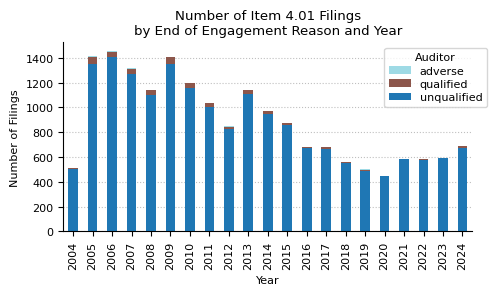

In [75]:
fig, ax = plt.subplots(figsize=(5, 3))

opinionType_year_pivot.drop(columns="total").T.plot(
    kind="bar", stacked=True, ax=ax, cmap="tab20"
)

ax.set_title("Number of Item 4.01 Filings\nby End of Engagement Reason and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]

ax.legend(
    reversed(handles),
    reversed(labels),
    title="Auditor",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()